<a href="https://colab.research.google.com/github/maimuna-noshin/NTK-PIKAN/blob/main/Vanilla_PINN%2CSA_PINN%2CNTK_PINN%2CNTK_PIKAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import Libraries

In [10]:
!pip install pykan torch numpy pandas matplotlib
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from torch.autograd.functional import jacobian
import warnings
warnings.filterwarnings('ignore')
from kan import KAN

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.1/78.1 kB 2.8 MB/s eta 0:00:00


# STEP 1: REALISTIC IEEE 13-NODE DATASET GENERATION (No OpenDSS Needed)

In [11]:
def generate_ieee13_fault_data(num_samples=5000, noise_level=0.08):
    ieee13_lines = {
        '650-632': (0.3460, 0.1560),
        '632-633': (0.3587, 0.1624),
        '671-684': (0.2270, 0.1030),
        '692-675': (0.2680, 0.1210)
    }


    data = []
    np.random.seed(42)


    for _ in range(num_samples):
        line = np.random.choice(list(ieee13_lines.keys()))
        R, X = ieee13_lines[line]
        Z_line = complex(R, X)


        d = np.random.uniform(0.1, 3.5)
        R_fault = np.random.uniform(10, 150)


        V_source = 1.0
        I_base = np.random.uniform(0.5, 2.0)
        angles = np.random.uniform(-0.2, 0.2, 3)
        I_phases = I_base * np.exp(1j * angles)


        Z_total = Z_line * d + complex(R_fault, 0)
        V_fault = V_source - np.mean(I_phases) * Z_total


        V_meas = V_fault + np.random.normal(0, noise_level) + 1j*np.random.normal(0, noise_level)
        I_meas = np.mean(I_phases) + np.random.normal(0, noise_level) + 1j*np.random.normal(0, noise_level)


        data.append([V_meas.real, V_meas.imag, I_meas.real, I_meas.imag, d])


    df = pd.DataFrame(data, columns=['V_re','V_im','I_re','I_im','Distance'])
    return df

In [12]:
data = generate_ieee13_fault_data()
inputs = torch.tensor(data[['V_re','V_im','I_re','I_im']].values, dtype=torch.float32)
labels = torch.tensor(data['Distance'].values, dtype=torch.float32).unsqueeze(1)

In [13]:
train_size = int(0.8 * len(inputs))
train_inputs, test_inputs = inputs[:train_size], inputs[train_size:]
train_labels, test_labels = labels[:train_size], labels[train_size:]

#  STEP 2: PHYSICS & NTK UTILITIES

In [14]:
Z_LINE = torch.tensor(0.5 + 0.3j, dtype=torch.complex64)


def data_loss(model, x, y):
    return nn.MSELoss()(model(x), y)


def physics_loss(model, x):
    preds = model(x).squeeze()
    V = torch.complex(x[:,0], x[:,1])
    I = torch.complex(x[:,2], x[:,3])
    V_calc = I * (Z_LINE * preds)
    return nn.MSELoss()(V.real, V_calc.real) + nn.MSELoss()(V.imag, V_calc.imag)


def compute_ntk_trace(model, loss_fn, x, *args):
    params = torch.cat([p.flatten() for p in model.parameters() if p.requires_grad])
    def wrapped(p_flat):
        idx = 0
        for p in model.parameters():
            if p.requires_grad:
                n = p.numel()
                p.data.copy_(p_flat[idx:idx+n].view(p.shape))
                idx += n
        return loss_fn(model, x, *args)
    J = jacobian(wrapped, params)
    return (torch.norm(J)**2).item()

# STEP 3: MODELS

In [15]:
class MLP_PINN(nn.Module):
    def __init__(self, h=128):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(4,h), nn.Tanh(),
            nn.Linear(h,h), nn.Tanh(),
            nn.Linear(h,h), nn.Tanh(),
            nn.Linear(h,1)
        )
    def forward(self,x): return self.net(x)


class SA_PINN(MLP_PINN):
    def __init__(self):
        super().__init__()
        self.lambda_net = nn.Sequential(
            nn.Linear(4,32), nn.Tanh(),
            nn.Linear(32,2), nn.Softplus()
        )
    def get_lambdas(self, x):
        w = self.lambda_net(x.mean(0, keepdim=True))
        return w[0,0], w[0,1]


class NTK_PINN(MLP_PINN):
    pass


class NTK_PIKAN(nn.Module):
    def __init__(self):
        super().__init__()
        self.kan = KAN(width=[4,5,5,1], grid=5, k=3)
    def forward(self,x): return self.kan(x)

# STEP 4: TRAINING FUNCTION (Unified)

In [16]:
def train(model, name, epochs=1500, lr=1e-3, mode="fixed"):
    opt = torch.optim.Adam(model.parameters(), lr=lr)
    losses = []


    lambda_data, lambda_phys = 1.0, 1.0


    for ep in range(epochs):
        opt.zero_grad()


        ld = data_loss(model, train_inputs, train_labels)
        lp = physics_loss(model, train_inputs)


        if mode == "ntk" and ep % 50 == 0:
            td = compute_ntk_trace(model, data_loss, train_inputs, train_labels)
            tp = compute_ntk_trace(model, physics_loss, train_inputs)
            lambda_phys = max(0.1, td / (tp + 1e-6))


        if mode == "sa":
            lambda_data, lambda_phys = model.get_lambdas(train_inputs)


        loss = lambda_data*ld + lambda_phys*lp
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        opt.step()


        losses.append(loss.item())


        if ep % 200 == 0:
            print(f"[{name}] Epoch {ep}: Loss={loss.item():.4f}, λ_phys={lambda_phys:.2f}")


    return model, losses

# STEP 5: RUN EXPERIMENTS

In [17]:
models = {
    "Vanilla PINN": (MLP_PINN(), "fixed"),
    "SA-PINN": (SA_PINN(), "sa"),
    "NTK-PINN": (NTK_PINN(), "ntk"),
    "NTK-PIKAN": (NTK_PIKAN(), "ntk")
}


results = {}
loss_curves = {}


for name,(model,mode) in models.items():
    print(f"\n Training {name}")
    m,l = train(model, name, mode=mode)
    loss_curves[name] = l
    with torch.no_grad():
        pred = m(test_inputs)
        mae = torch.mean(torch.abs(pred - test_labels)).item()
    results[name] = mae

checkpoint directory created: ./model
saving model version 0.0

🚀 Training Vanilla PINN
[Vanilla PINN] Epoch 0: Loss=13800.2695, λ_phys=1.00
[Vanilla PINN] Epoch 200: Loss=10950.7979, λ_phys=1.00
[Vanilla PINN] Epoch 400: Loss=10095.6406, λ_phys=1.00
[Vanilla PINN] Epoch 600: Loss=9847.3291, λ_phys=1.00
[Vanilla PINN] Epoch 800: Loss=9737.1582, λ_phys=1.00
[Vanilla PINN] Epoch 1000: Loss=9677.1592, λ_phys=1.00
[Vanilla PINN] Epoch 1200: Loss=9640.5928, λ_phys=1.00
[Vanilla PINN] Epoch 1400: Loss=9616.4834, λ_phys=1.00

🚀 Training SA-PINN
[SA-PINN] Epoch 0: Loss=7662.4502, λ_phys=0.56
[SA-PINN] Epoch 200: Loss=3.4733, λ_phys=0.00
[SA-PINN] Epoch 400: Loss=0.0294, λ_phys=0.00
[SA-PINN] Epoch 600: Loss=0.0113, λ_phys=0.00
[SA-PINN] Epoch 800: Loss=0.0065, λ_phys=0.00
[SA-PINN] Epoch 1000: Loss=0.0043, λ_phys=0.00
[SA-PINN] Epoch 1200: Loss=0.0031, λ_phys=0.00
[SA-PINN] Epoch 1400: Loss=0.0023, λ_phys=0.00

🚀 Training NTK-PINN (Ours)
[NTK-PINN (Ours)] Epoch 0: Loss=1387.0148, λ_phys=0.10
[

# STEP 6: RESULTS & PLOTS

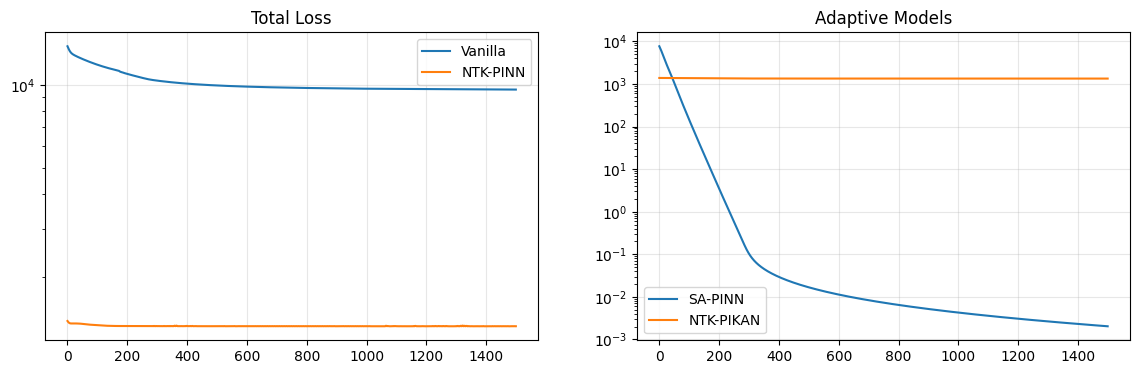

In [18]:
plt.figure(figsize=(14,4))


plt.subplot(1,2,1)
plt.plot(loss_curves["Vanilla PINN"], label="Vanilla")
plt.plot(loss_curves["NTK-PINN (Ours)"], label="NTK-PINN")
plt.yscale("log")
plt.title("Total Loss")
plt.legend(); plt.grid(alpha=0.3)


plt.subplot(1,2,2)
plt.plot(loss_curves["SA-PINN"], label="SA-PINN")
plt.plot(loss_curves["NTK-PIKAN (Ours+)"], label="NTK-PIKAN")
plt.yscale("log")
plt.title("Adaptive Models")
plt.legend(); plt.grid(alpha=0.3)


plt.show()
